
## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.


## **Project Topic:** Predicting customer retention based on subscription model


**Business Problem:** This project aims to predict customer churn for a subscription-based service and identify key factors contributing to churn, enabling targeted retention strategies to minimize revenue loss.  Customer churn occurs when customers end their relationship or subscription with a company. It measures how many customers stop using a company's products or services over time and affects revenue, growth, and customer retention.

Customer churn can have significant impacts on a business's financial health and market position. High churn rates may indicate underlying issues such as poor customer service, product dissatisfaction, high competition, incorrect pricing or ineffective marketing strategies. 

By addressing customer churn proactively, companies can improve their customer retention rates, maximize lifetime customer value, and ensure long-term sustainable growth.


### 1. Import Libraries
Import and install the required libraries

In [0]:
pip install tensorflow

In [0]:
pip install tabulate

In [0]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, stddev
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import numpy as np


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # Scikit-learn NN
from tensorflow import keras # Keras NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



import matplotlib.pyplot as plt
import seaborn as sns


import warnings

import plotly.express as px

#import tensorflow as tf
#from tensorflow.keras import Sequential  
#from tensorflow.keras.layers import Dense, Dropout, InputLayer
#from tensorflow.keras.optimizers import Adam  
from tabulate import tabulate

2025-02-08 23:23:57.274276: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-08 23:23:57.279083: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-08 23:23:57.289491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739057037.306133    2485 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739057037.310436    2485 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 23:23:57.329575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### 2. Load the Data

In [0]:
# File location and type
file_location = "/FileStore/tables/customer_churn_dataset_training_master-1.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df.head(10))

CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
2,30,Female,39,14,5,18,Standard,Annual,932,17,1
3,65,Female,49,1,10,8,Basic,Monthly,557,6,1
4,55,Female,14,4,6,18,Basic,Quarterly,185,3,1
5,58,Male,38,21,7,7,Standard,Monthly,396,29,1
6,23,Male,32,20,5,8,Basic,Monthly,617,20,1
8,51,Male,33,25,9,26,Premium,Annual,129,8,1
9,58,Female,49,12,3,16,Standard,Quarterly,821,24,1
10,55,Female,37,8,4,15,Premium,Annual,445,30,1
11,39,Male,12,5,7,4,Standard,Quarterly,969,13,1
12,64,Female,3,25,2,11,Standard,Quarterly,415,29,1


In [0]:
# Spark DataFrame
pandas_df = df.toPandas() 

# Pandas DataFrame (pandas_df)
(pandas_df.head(3))

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2,30,Female,39,14,5,18,Standard,Annual,932,17,1
1,3,65,Female,49,1,10,8,Basic,Monthly,557,6,1
2,4,55,Female,14,4,6,18,Basic,Quarterly,185,3,1


In [0]:
pandas_df['Churn'].value_counts()

1    249999
0    190833
Name: Churn, dtype: int64

### 3. Data Exploration

Fing the total quanity of the data, missing data, na values, outliers, maximum, minimum

In [0]:
#Convert the data to appropriate datatype 
pandas_df['CustomerID'] = pandas_df['CustomerID'].astype('string')
pandas_df['Age'] = pandas_df['Age'].astype(float)
pandas_df['Gender'] = pandas_df['Gender'].astype('category')
pandas_df['Tenure'] = pandas_df['Tenure'].astype(float)
pandas_df['Usage Frequency'] = pandas_df['Usage Frequency'].astype(float)
pandas_df['Support Calls']=pandas_df['Support Calls'].astype(float)
pandas_df['Payment Delay']=pandas_df['Payment Delay'].astype(float)
pandas_df['Subscription Type']=pandas_df['Subscription Type'].astype('category')
pandas_df['Contract Length']=pandas_df['Contract Length'].astype('category')
pandas_df['Total Spend']=pandas_df['Total Spend'].astype(float)
pandas_df['Last Interaction']=pandas_df['Last Interaction'].astype(float)
pandas_df['Churn']=np.where(pandas_df['Churn'].str.lower() == '1', True, False)


In [0]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   CustomerID         440832 non-null  string  
 1   Age                440832 non-null  float64 
 2   Gender             440832 non-null  category
 3   Tenure             440832 non-null  float64 
 4   Usage Frequency    440832 non-null  float64 
 5   Support Calls      440832 non-null  float64 
 6   Payment Delay      440832 non-null  float64 
 7   Subscription Type  440832 non-null  category
 8   Contract Length    440832 non-null  category
 9   Total Spend        440832 non-null  float64 
 10  Last Interaction   440832 non-null  float64 
 11  Churn              440833 non-null  bool    
dtypes: bool(1), category(3), float64(7), string(1)
memory usage: 28.6 MB


In [0]:
def explore_data(df):
    results = []
    for col in df.columns:
        # Count missing values (NaN)
        missing_count = df[col].isnull().sum()
        # Count NA values (as a string)
        na_count = df[col].astype(str).str.contains('NA').sum()
        # Count total values
        total_count = len(df[col])
        # Calculate percentage of missing and NA values
        missing_percent = (missing_count / total_count) * 100
        na_percent = (na_count / total_count) * 100
        # Determine data type
        data_type = df[col].dtype

# --- Additional Checks ---

        # Unique values
        unique_count = df[col].nunique()

        # Detect outliers (using IQR method)
        if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):  # Only for numeric
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        else:
            outlier_count = np.nan  # Not applicable for non-numeric

        # Minimum and Maximum values
        if pd.api.types.is_numeric_dtype(df[col]):
            minimum = df[col].min()
            maximum = df[col].max()
            skewness = df[col].skew()
        else:
            minimum = np.nan
            maximum = np.nan
            skewness = np.nan
            
        results.append([
            col, total_count, missing_count, missing_percent, 
            na_count, na_percent, data_type, unique_count, 
            outlier_count, minimum, maximum, skewness  
        ])

    exploration_df = pd.DataFrame(results, columns=[
        "Column", "Total Count", "Missing Count", "Missing (%)", 
        "NA Count", "NA (%)", "Data Type", "Unique Values", 
        "Outlier Count", "Minimum", "Maximum", "Skewness"
    ])
    return exploration_df

# Perform data exploration
exploration_results = explore_data(pandas_df)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
exploration_results.head(100)


,Column,Total Count,Missing Count,Missing (%),NA Count,NA (%),Data Type,Unique Values,Outlier Count,Minimum,Maximum,Skewness
0,CustomerID,440833,1,0.000227,1,0.000227,string,440832,NaN,NaN,NaN,NaN
1,Age,440833,1,0.000227,0,0.000000,float64,48,0.0,18.0,65.0,0.162016
2,Gender,440833,1,0.000227,0,0.000000,category,2,NaN,NaN,NaN,NaN
3,Tenure,440833,1,0.000227,0,0.000000,float64,60,0.0,1.0,60.0,-0.061402
4,Usage Frequency,440833,1,0.000227,0,0.000000,float64,30,0.0,1.0,30.0,-0.043473
5,Support Calls,440833,1,0.000227,0,0.000000,float64,11,0.0,0.0,10.0,0.666809
6,Payment Delay,440833,1,0.000227,0,0.000000,float64,31,0.0,0.0,30.0,0.267407
7,Subscription Type,440833,1,0.000227,0,0.000000,category,3,NaN,NaN,NaN,NaN
8,Contract Length,440833,1,0.000227,0,0.000000,category,3,NaN,NaN,NaN,NaN
9,Total Spend,440833,1,0.000227,0,0.000000,float64,68363,0.0,100.0,1000.0,-0.457174


### 4. Data Preparation

Selecting below columns for anlaysis, removing columns with high number of NAs:


In [0]:
select_columns = ['Age','Gender','Tenure','Usage Frequency','Support Calls','Payment Delay','Subscription Type','Contract Length','Total Spend', 'Last Interaction'	]

data_df = pandas_df[select_columns]

data_df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868
std,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000
25%,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000
50%,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000
75%,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000


In [0]:
# Drop NA records
#data_df.replace(['NA', 'Na'], pd.NA, inplace=True)
#data_df['Thermal comfort'].replace('Na', pd.NA, inplace=True)
data_df = data_df.dropna(how='any')

In [0]:
#Check data after dropping NAs
exploration_results = explore_data(data_df)
exploration_results.head(100)

,Column,Total Count,Missing Count,Missing (%),NA Count,NA (%),Data Type,Unique Values,Outlier Count,Minimum,Maximum,Skewness
0,Age,440832,0,0.0,0,0.0,float64,48,0.0,18.0,65.0,0.162016
1,Gender,440832,0,0.0,0,0.0,category,2,NaN,NaN,NaN,NaN
2,Tenure,440832,0,0.0,0,0.0,float64,60,0.0,1.0,60.0,-0.061402
3,Usage Frequency,440832,0,0.0,0,0.0,float64,30,0.0,1.0,30.0,-0.043473
4,Support Calls,440832,0,0.0,0,0.0,float64,11,0.0,0.0,10.0,0.666809
5,Payment Delay,440832,0,0.0,0,0.0,float64,31,0.0,0.0,30.0,0.267407
6,Subscription Type,440832,0,0.0,0,0.0,category,3,NaN,NaN,NaN,NaN
7,Contract Length,440832,0,0.0,0,0.0,category,3,NaN,NaN,NaN,NaN
8,Total Spend,440832,0,0.0,0,0.0,float64,68363,0.0,100.0,1000.0,-0.457174
9,Last Interaction,440832,0,0.0,0,0.0,float64,30,0.0,1.0,30.0,0.176774


In [0]:
#describe the data
data_df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868
std,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000
25%,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000
50%,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000
75%,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000


### 5. Visualize the Data

**Correlation Matrix:** Correlations between numerical features.

/root/.ipykernel/2485/command-749310788137394-3861020466:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_df.corr()


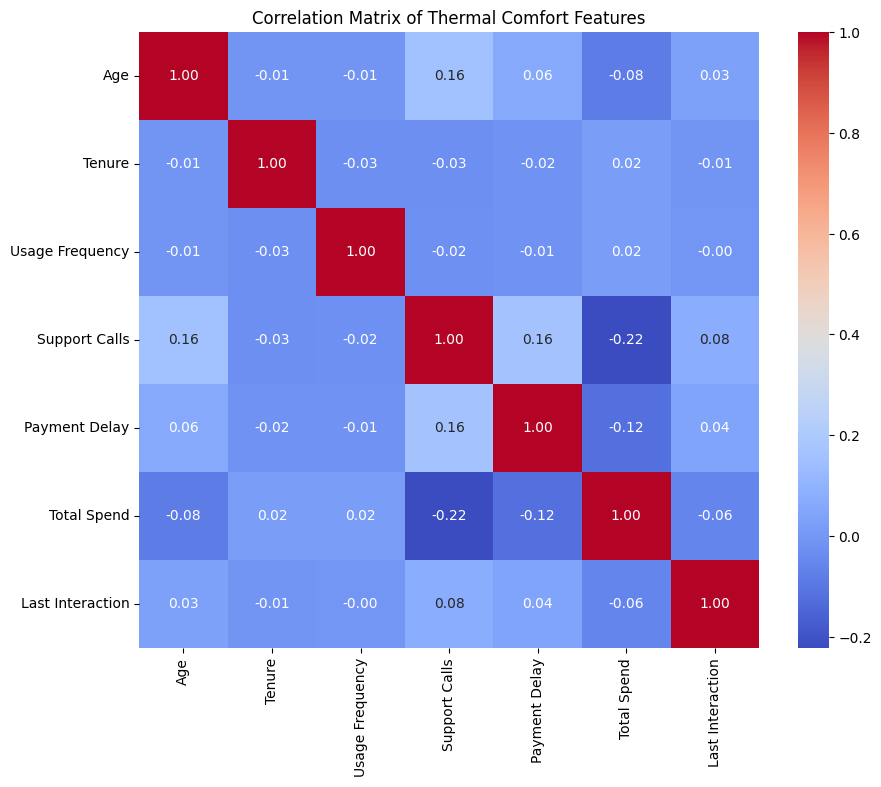

In [0]:
# Calculate the correlation matrix
corr_matrix = data_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Thermal Comfort Features')
plt.show()

**Pair Plot:** To see both distributions of individual variables and their relationships

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


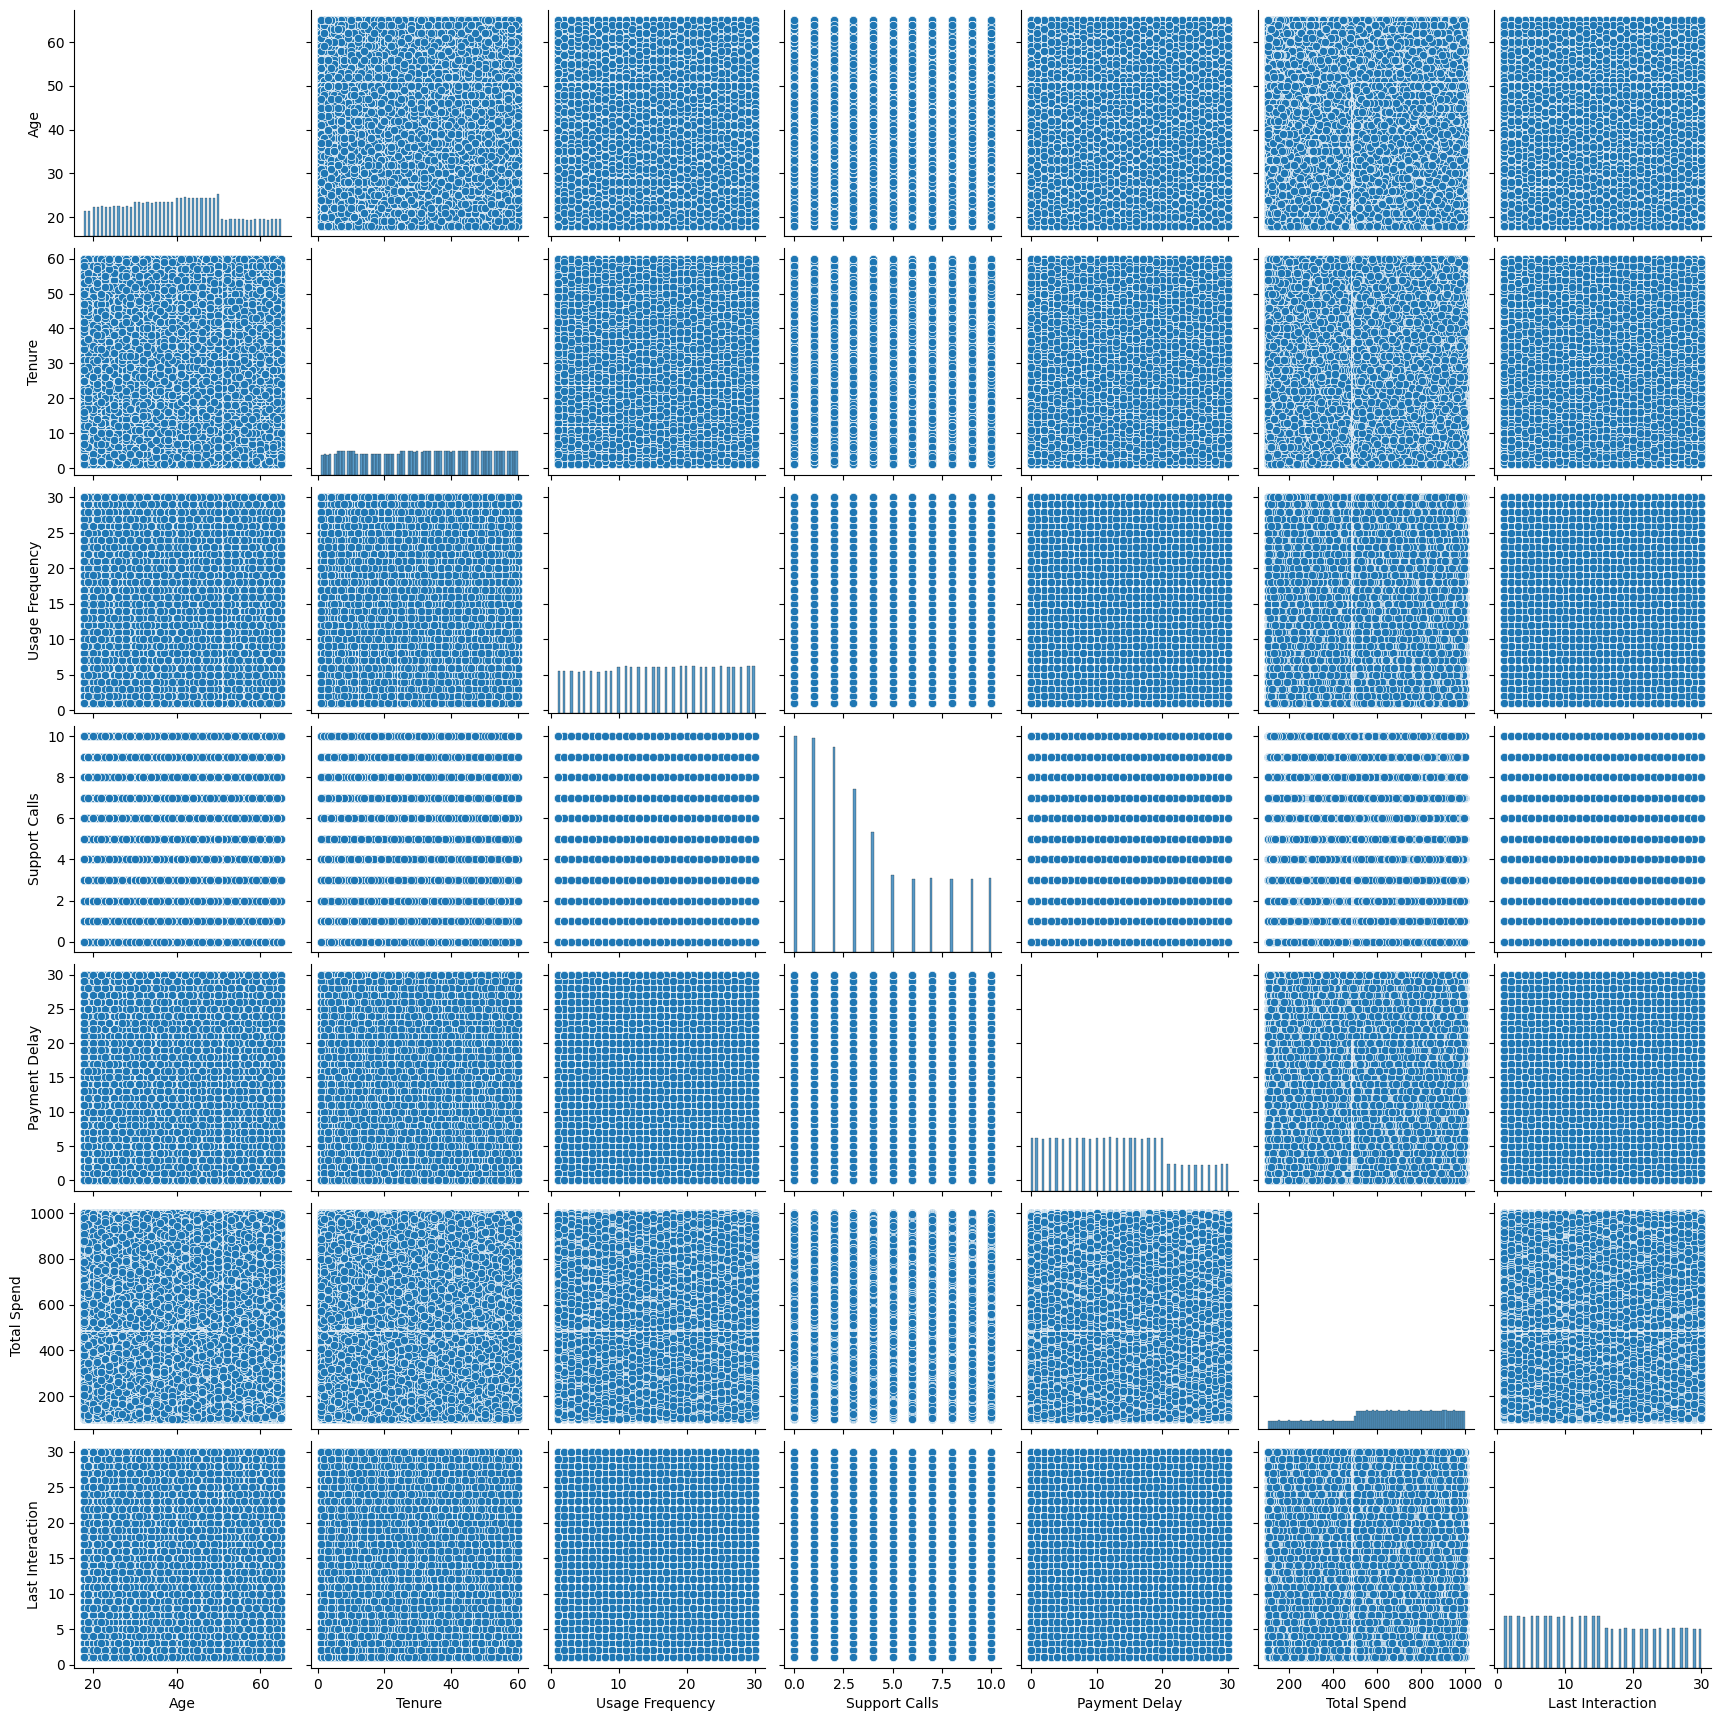

In [0]:
sns.pairplot(data_df)
plt.show()

**Box Plot**
 Distribution of a numerical variable across different categories.

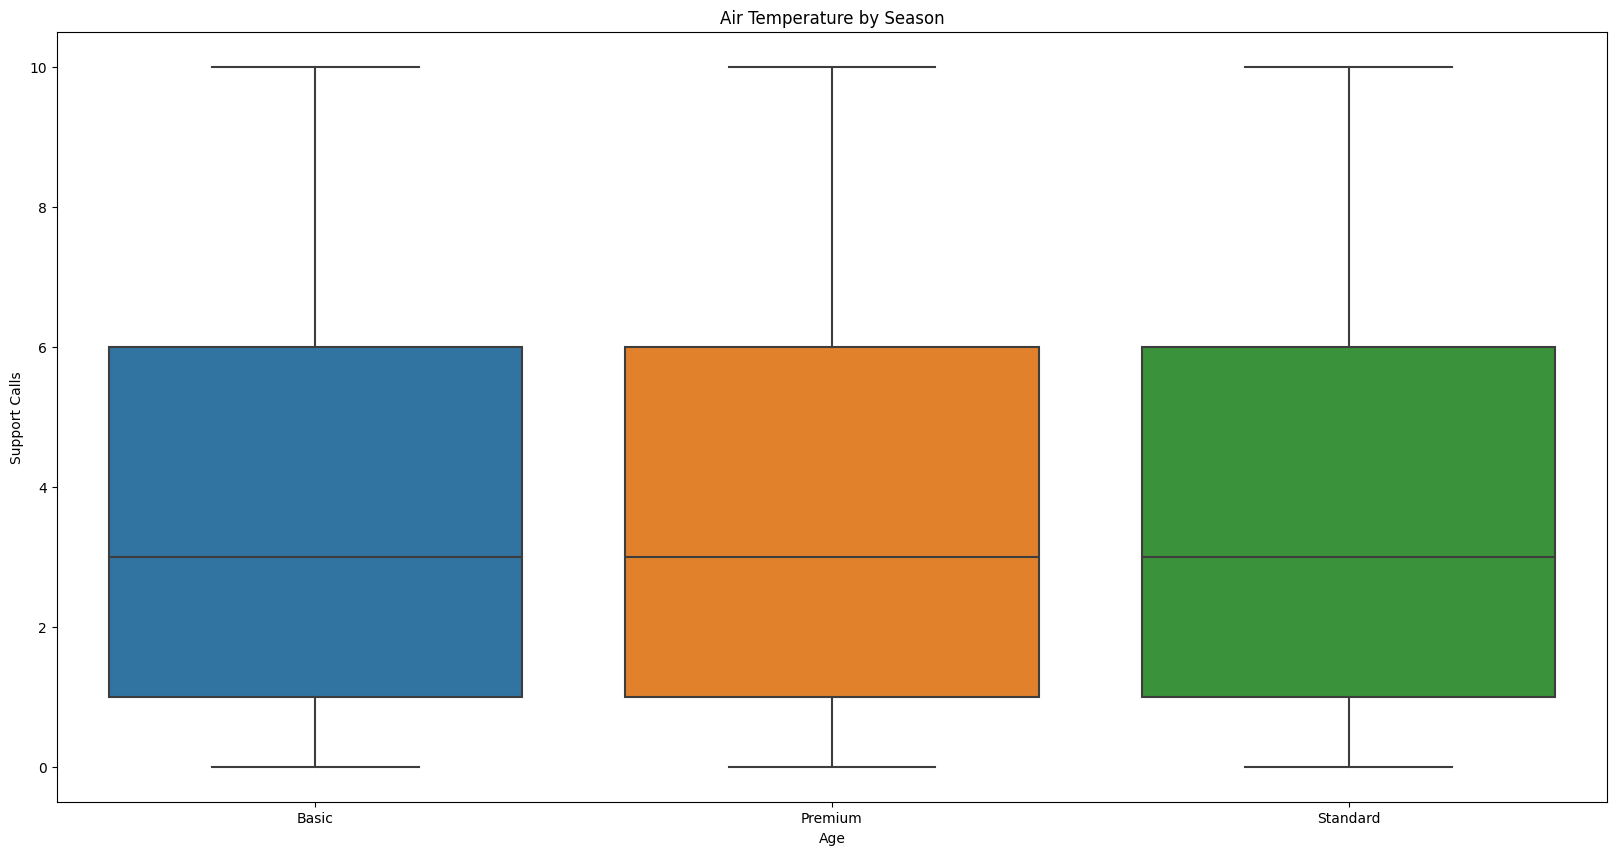

In [0]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Subscription Type', y='Support Calls', data=data_df)
plt.xlabel('Age')
plt.ylabel('Support Calls')
plt.title('Air Temperature by Season')
plt.show()

Violin Plots Density of the data distribution.

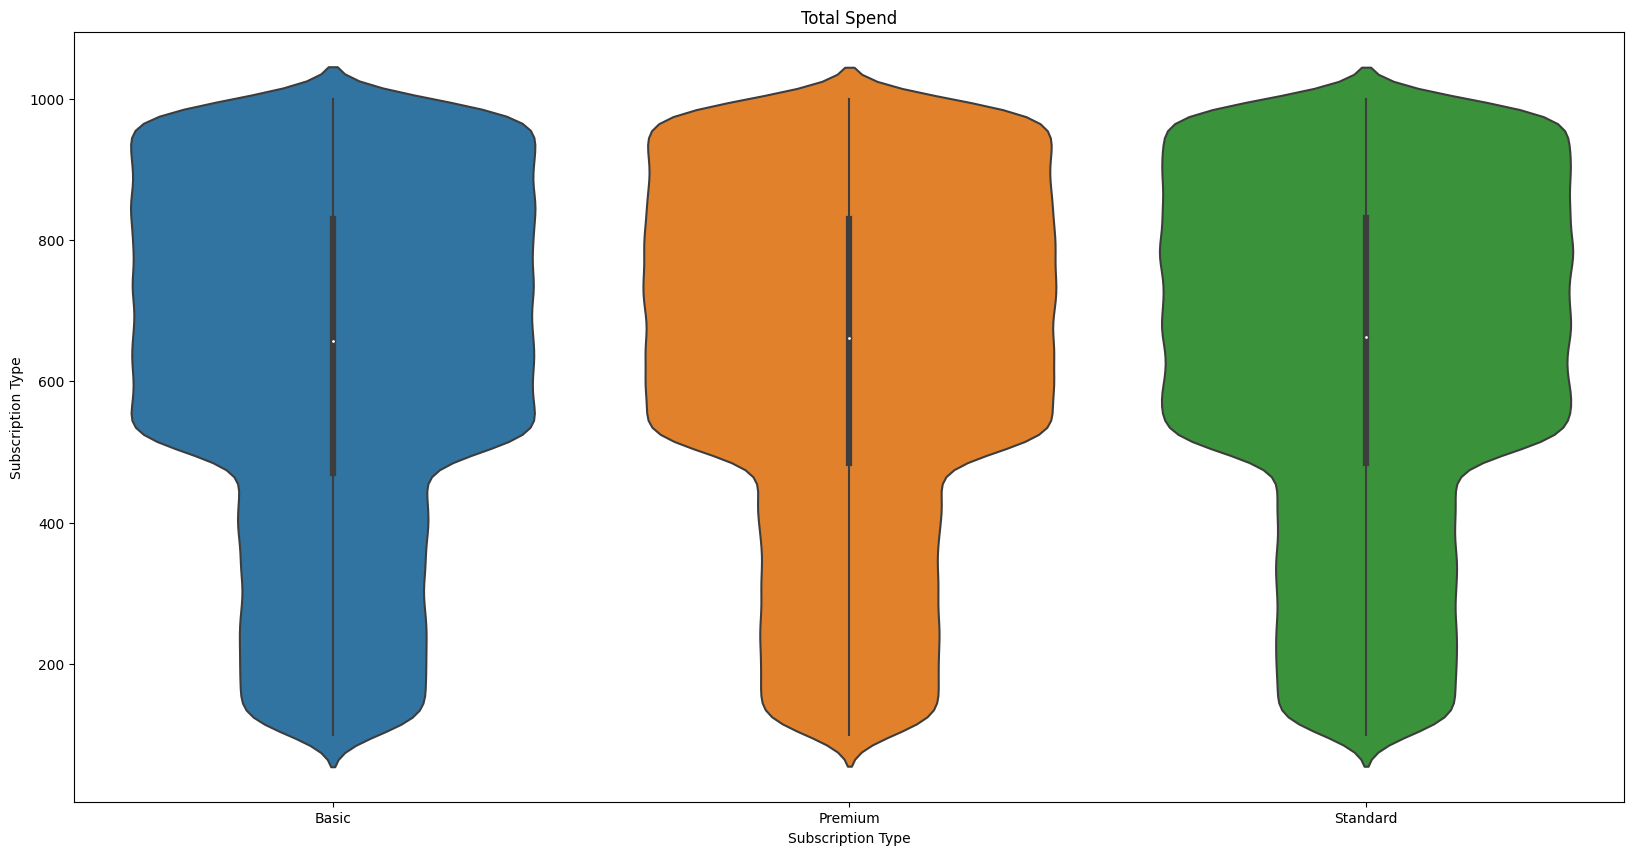

In [0]:
plt.figure(figsize=(20, 10))
sns.violinplot(x='Subscription Type', y='Total Spend', data=data_df)
plt.xlabel('Subscription Type')
plt.ylabel('Subscription Type')
plt.title('Total Spend')
plt.show()

In [0]:
#plt.figure(figsize=(20, 10))
#sns.countplot(x='Koppen climate classification', data=data_df)
#plt.xlabel('Koppen Climate Classification')
#plt.ylabel('Count')
#plt.title('Frequency of Koppen Climate Classifications')
#plt.xticks(rotation=45)  # Rotate x-axis labels if needed
#plt.show()

In [0]:
#**World map** Country Vs Child mortality

#plt.figure(figsize=(20, 10))
## Create the world map
#fig = px.choropleth(data_df,
#                    locations='country',
#                    locationmode='country names',
#                    color='child_mort',  # Choose the column you want to visualize
#                    hover_data=['gdpp', 'life_expec', 'total_fer'],
#                    color_continuous_scale='Viridis',  # Choose a color scale
#                    title='Child Mortality Rate Around the World',
#                    width=1200, 
#                    height=800)

#fig.show()

In [0]:
#**World Map** Country Vs GDP
# Create the world map
#fig = px.choropleth(data_df,
#                    locations='country',
#                    locationmode='country names',
#                    color='gdpp',  
#                    hover_data=['gdpp', 'life_expec', 'total_fer'],
#                    color_continuous_scale='Viridis',  
#                    title='GDP around the World',
#                    width=1200, 
#                    height=800)

#fig.show()

### 6. Model Training

In [0]:
pandas_df.size

5289996

In [0]:
datatrain__df.size

5289996

In [0]:
pandas_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,True
1,3,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,True
2,4,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,True
3,5,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,True
4,6,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,True


In [0]:
pandas_df['Churn'].value_counts()

True     249999
False    190834
Name: Churn, dtype: int64

In [0]:
datatrain__df= pandas_df.copy()
label = LabelEncoder()
datatrain__df['Gender'] = label.fit_transform(datatrain__df['Gender'])
datatrain__df['Subscription Type'] = label.fit_transform(datatrain__df['Subscription Type'])
datatrain__df['Contract Length'] = label.fit_transform(datatrain__df['Contract Length'])
(datatrain__df.head())

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2,30.0,0,39.0,14.0,5.0,18.0,2,0,932.0,17.0,True
1,3,65.0,0,49.0,1.0,10.0,8.0,0,1,557.0,6.0,True
2,4,55.0,0,14.0,4.0,6.0,18.0,0,2,185.0,3.0,True
3,5,58.0,1,38.0,21.0,7.0,7.0,2,1,396.0,29.0,True
4,6,23.0,1,32.0,20.0,5.0,8.0,0,1,617.0,20.0,True


In [0]:
print(pd.unique(datatrain__df['Churn']))
print(len(pd.unique(datatrain__df['Churn'])))

[ True False]
2


In [0]:
datatrain__df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')

In [0]:
column_to_scale = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
scaler = StandardScaler()
for colm in column_to_scale:
    datatrain__df[colm] = scaler.fit_transform(datatrain__df[colm].values.reshape(-1,1))

In [0]:
datatrain__df.describe()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
count,4.408320e+05,440833.000000,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,440833.000000,440833.000000,4.408320e+05,4.408320e+05
mean,1.119249e-16,0.567684,2.076027e-17,-1.727873e-17,6.189397e-17,4.538891e-17,1.013847,0.998489,5.054674e-17,9.799878e-17
std,1.000001e+00,0.495403,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.813972,0.895777,1.000001e+00,1.000001e+00
min,-1.717774e+00,0.000000,-1.753410e+00,-1.724562e+00,-1.174002e+00,-1.570070e+00,0.000000,0.000000,-2.207684e+00,-1.568236e+00
25%,-8.336969e-01,0.000000,-8.841327e-01,-7.928383e-01,-8.482914e-01,-8.435065e-01,0.000000,0.000000,-6.296283e-01,-8.702531e-01
50%,-2.999058e-02,1.000000,4.309671e-02,2.242036e-02,-1.968711e-01,-1.169430e-01,1.000000,1.000000,1.220243e-01,-5.593961e-02
75%,6.933451e-01,1.000000,8.544225e-01,8.376790e-01,7.802593e-01,7.307144e-01,2.000000,2.000000,8.238436e-01,8.747044e-01
max,2.059646e+00,2.000000,1.665748e+00,1.652938e+00,2.083100e+00,2.062747e+00,3.000000,3.000000,1.529816e+00,1.805348e+00


In [0]:
datatrain__df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  string 
 1   Age                440832 non-null  float64
 2   Gender             440833 non-null  int64  
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440833 non-null  int64  
 8   Contract Length    440833 non-null  int64  
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440833 non-null  bool   
dtypes: bool(1), float64(7), int64(3), string(1)
memory usage: 37.4 MB


In [0]:
print(pd.unique(datatrain__df['Churn']))
print(len(pd.unique(datatrain__df['Churn'])))

[ True False]
2


In [0]:
datatrain__df.isnull().sum()

CustomerID           1
Age                  1
Gender               0
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    0
Contract Length      0
Total Spend          1
Last Interaction     1
Churn                0
dtype: int64

In [0]:
datatrain__df.shape

(440833, 12)

In [0]:
datatrain__df['Churn'].value_counts()

True     249999
False    190834
Name: Churn, dtype: int64

In [0]:
datatrain__df= datatrain__df.dropna()

In [0]:
datatrain__df.shape

(440832, 12)

In [0]:
print(pd.unique(datatrain__df['Churn']))
print(len(pd.unique(datatrain__df['Churn'])))

[ True False]
2


In [0]:
# Define features (X) and target (y)
X = datatrain__df.drop(['Churn','CustomerID'], axis=1)  # All columns except 'Churn'
y = datatrain__df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)  # 80% train, 20% test


In [0]:
print(pd.unique(pandas_df['Churn']))
print(len(pd.unique(pandas_df['Churn'])))

[ True False]
2


In [0]:
#Selecting different models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Scikit-learn NN": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42), # Added Scikit Learn NN
    "Keras NN": None  # We'll define this separately
}


In [0]:
# Keras NN Model Definition
keras_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # Input layer, needs input dimensions
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
])

/local_disk0/.ephemeral_nfs/envs/pythonEnv-50a14892-c772-46ae-b460-71bd9fa2beab/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [0]:
keras_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
models["Keras NN"] = keras_nn

%md
#### 7. Evaluation Matrix

In [0]:
for name, model in models.items():
    print(f"Training and evaluating {name}...")

    if name == "Keras NN":
      model.fit(X_train, y_train, epochs=50, batch_size=32, verbose = 0) # Train Keras model
      y_pred_probs = model.predict(X_test) # Get probabilities
      y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to classes (0 or 1)
    else:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

Training and evaluating Logistic Regression...
Logistic Regression Accuracy: 0.8511
              precision    recall  f1-score   support

       False       0.81      0.85      0.83     76234
        True       0.88      0.85      0.87    100099

    accuracy                           0.85    176333
   macro avg       0.85      0.85      0.85    176333
weighted avg       0.85      0.85      0.85    176333

[[64812 11422]
 [14826 85273]]
--------------------------------------------------
Training and evaluating Random Forest...
Random Forest Accuracy: 0.9996
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     76234
        True       1.00      1.00      1.00    100099

    accuracy                           1.00    176333
   macro avg       1.00      1.00      1.00    176333
weighted avg       1.00      1.00      1.00    176333

[[ 76231      3]
 [    66 100033]]
--------------------------------------------------
Training and evaluatin

In [0]:
data_df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'cluster_optimized'],
      dtype='object')

#### 7. Evaluation Matrix

In [0]:

# Assuming Y_test and Y_pred are your true and predicted labels respectively

#results =[]
#for k in range(2, 11):  # Example range
#    kmeans = KMeans(n_clusters=k, random_state=48)
#    kmeans.fit(datatrain__df[column_to_scale])
    
#    inertia = kmeans.inertia_
#    labels = kmeans.labels_
#    silhouette_avg = silhouette_score(datatrain__df[column_to_scale], labels)
    
#    results.append([k, inertia, silhouette_avg])
# Accuracy
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f"Accuracy: {accuracy}")

# Precision
#precision = precision_score(Y_test, Y_pred, average='macro')  # or 'micro', 'weighted'
#print(f"Precision: {precision}")

# Recall
#recall = recall_score(Y_test, Y_pred, average='macro')  # or 'micro', 'weighted'
#print(f"Recall: {recall}")

# F1-score
#f1 = f1_score(Y_test, Y_pred, average='macro')  # or 'micro', 'weighted'
#print(f"F1-score: {f1}")

# Confusion Matrix
#cm = confusion_matrix(Y_test, Y_pred)
#print("Confusion Matrix:")
#print(cm)

# Classification Report
#cr = classification_report(Y_test, Y_pred)
#print("Classification Report:")
#print(cr)

In [0]:
# Print the results in a table
#headers = ["k", "Inertia", "Silhouette Score"]
#print(tabulate(results, headers=headers, tablefmt="fancy_grid"))  # Use "fancy_grid" for a grid-like table

╒═════╤═══════════╤════════════════════╕
│   k │   Inertia │   Silhouette Score │
╞═════╪═══════════╪════════════════════╡
│   2 │  1216.56  │           0.252237 │
├─────┼───────────┼────────────────────┤
│   3 │   998.052 │           0.240437 │
├─────┼───────────┼────────────────────┤
│   4 │   866.288 │           0.253132 │
├─────┼───────────┼────────────────────┤
│   5 │   798.433 │           0.190767 │
├─────┼───────────┼────────────────────┤
│   6 │   704.634 │           0.206032 │
├─────┼───────────┼────────────────────┤
│   7 │   646.887 │           0.197967 │
├─────┼───────────┼────────────────────┤
│   8 │   591.877 │           0.213158 │
├─────┼───────────┼────────────────────┤
│   9 │   556.605 │           0.20009  │
├─────┼───────────┼────────────────────┤
│  10 │   526.484 │           0.197546 │
╘═════╧═══════════╧════════════════════╛


As we can see from the results, K=4 provides best results. At K=4, Silhouette Score is maximum and the slope on elbo drops down significantly.